In [1]:
import os
import json
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from analyticalSolver import generateQUBO, isInputValid, decodeBitstring

In [2]:
SHOTS = 512
DOMAIN = np.linspace(0, 100, 1000)

# Energy Spectrum

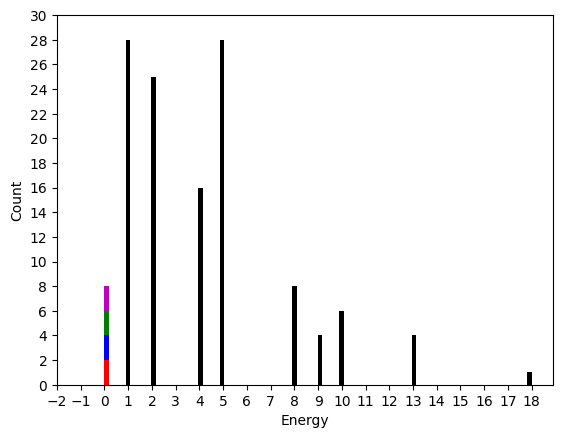

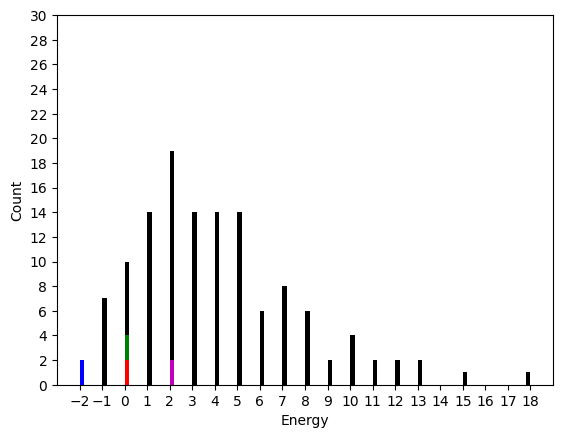

In [3]:
# Set constant variables.
N = 3
PENALTIES = [None, [2, -2]]

# For each penalty value:
for idx, penalty in enumerate(PENALTIES):

    # Generate the corresponding QUBO.
    Q = generateQUBO(N, penalty, True)

    # Get the number of qubits in the problem.
    num_qubits = len(Q)

    # Instantiate needed data structures.
    valid = dict()
    invalid = []

    # For each possible assignment of classical values to the qubits:
    for i in range(2**num_qubits):

        # Compute the expectation of that bitstring with the QUBO.
        x = np.array(list(map(int, list(format(i, f'0{num_qubits}b')))))
        expectation = x.T @ Q @ x

        # Decode the bitstring and check if it is valid.
        inputs, outputs, ancillas = decodeBitstring(x)
        isValid = isInputValid(inputs, outputs, ancillas)

        # Record the bitstring and its expectation in the proper structures.
        if isValid:
            key = ''.join(map(str, outputs))
            if key in valid:
                valid[key].append(expectation)
            else:
                valid[key] = [expectation]
        else:
            invalid.append(expectation)
        decodedString = str(
            ''.join(map(str, inputs)) + ' ' +
            ''.join(map(str, outputs)) + ' ' +
            ''.join(map(str, ancillas))
        )

    # plt.figure(figsize=(10,10))

    # Plot the results in a histogram.
    categories = [valid[result] for result in valid]
    categories.append(invalid)
    plt.hist(
        categories,
        bins=100,
        color=['r', 'b', 'g', 'm', 'k'],
        histtype='barstacked',
        label=['Valid', 'Valid', 'Valid', 'Valid', 'Invalid']
    )

    # Label the plot.
    plt.xticks(range(-2, 19, 1))
    plt.yticks(range(0, 31, 2))
    plt.xlabel(f'Energy')
    plt.ylabel(f'Count')

    # Save the plot.
    plt.show()
    plt.close()

# D-Wave Success Probability of Problem Size

In [51]:
def Exponential(x, a):
    return np.exp(a*x)

def Guassian(x, a):
    return np.exp(a*x**2)

def func(x):
    return np.maximum(np.exp(-0.00128404*x**2), np.exp(-0.062*x))

def Mixture(x, a, b):
    return np.maximum(np.exp(a*x**2), np.exp(b*x))

In [52]:
# balanced = dict()
# random = dict()
# for filename in os.listdir('../data/nonuniformPenalties'):
#     n = int(filename[:filename.find('[')].split('-')[1])
#     penalties = json.loads(filename[filename.find('['):filename.find(']')+1])
#     time = int(filename[filename.find(']'):].split('-')[1])
#     if time != 100 or 5 in penalties:
#         continue
#     with open(f'../data/nonuniformPenalties/{filename}') as file:
#         counts = file.readlines()
#     assert str(int(counts[0].split(' ')[0]) + int(counts[1].split(' ')[0])) == '1' * n
#     p = (int(counts[0].split(':')[1]) + int(counts[1].split(':')[1]))/SHOTS
#     if n == 2:
#         balanced[n] = p
#         random[n] = p
#     elif penalties == [2*(-1)**(i) for i in range(n-1)]:
#         balanced[n] = p
#     else:
#         random[n] = p

# balanced = dict(sorted(balanced.items()))
# random = dict(sorted(random.items()))
# print(balanced)

# xVals = list(balanced.keys()) + list(random.keys())
# yVals = list(balanced.values()) + list(random.values())

# popt, pcov = curve_fit(F, xVals, yVals)

# plt.semilogy(balanced.keys(), balanced.values(), '.')
# plt.semilogy(random.keys(), random.values(), '.')
# plt.semilogy(DOMAIN, F(DOMAIN, *popt))
# plt.show()

{5: 0.9815, 10: 0.892, 15: 0.612, 20: 0.5215, 25: 0.3475, 30: 0.17125, 35: 0.2165, 40: 0.0865, 45: 0.1005, 50: 0.0585, 55: 0.022, 60: 0.0395, 65: 0.0155, 70: 0.0225, 75: 0.0255, 80: 0.0065, 85: 0.00775, 90: 0.0035, 95: 0.002, 100: 0.00275}


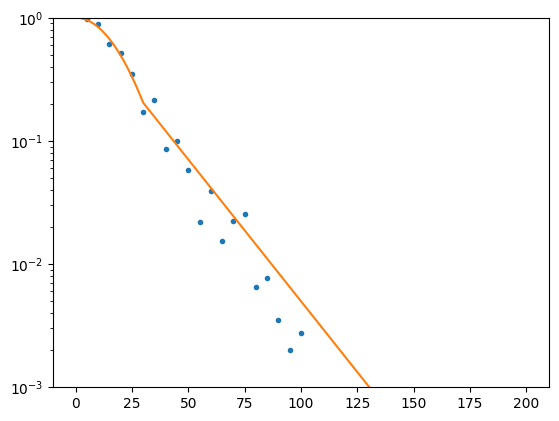

[-0.00176678 -0.0530035 ]


In [53]:
balanced = dict()
for filename in os.listdir('../data/balancedPenalties'):
    device, n, time, shots = filename[:-4].split('-')
    n, time, shots = int(n), int(time), int(shots)
    with open(f'../data/balancedPenalties/{filename}') as file:
        counts = file.readlines()
    assert str(int(counts[0].split(' ')[0]) + int(counts[1].split(' ')[0])) == '1' * n
    p = (int(counts[0].split(':')[1]) + int(counts[1].split(':')[1]))/shots
    balanced[n] = p

balanced = dict(sorted(balanced.items()))
print(balanced)

# popt, pcov = curve_fit(F, list(balanced.keys()), list(balanced.values()), p0=[-.001])

popt, pcov = curve_fit(Mixture, list(balanced.keys()), list(balanced.values()), p0=[-.001, -0.062])

plt.semilogy(balanced.keys(), balanced.values(), '.')
plt.semilogy(DOMAIN, Mixture(DOMAIN, *popt))
# plt.semilogy(DOMAIN, np.exp(-0.062*DOMAIN))
# plt.semilogy(DOMAIN, func(DOMAIN))
plt.ylim(10**-3, 1)
plt.show()
plt.close()

# plt.plot(balanced.keys(), balanced.values(), '.')
# plt.plot(DOMAIN, F(DOMAIN, *popt))
# plt.show()

print(popt)

# Plot 3

In [61]:
import pickle

data = dict()

data['xVals'] = list(balanced.keys())
data['yVals'] =list(balanced.values())

# plt.semilogy(xVals, yVals, '.')
# plt.semilogy(DOMAIN, 2/Mixture(DOMAIN, *popt) * 100e-6)
# # plt.semilogy(DOMAIN, 2**(DOMAIN - 1))
# plt.show()

with open('../figureData/plot3.pkl', 'wb') as file:
    pickle.dump(data, file)
#     file.write(str(xVals))
#     file.write(str(yVals))

# Plot 4

In [46]:
def Quadratic(x, a, b, c):
    return a * x**2 + b * x + c

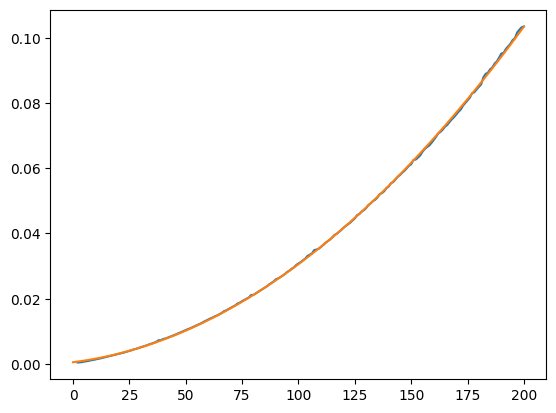

[2.13797617e-06 8.67385804e-05 5.29931574e-04]


In [48]:
classical = [np.float64(0.00044956207275390623), np.float64(0.0004747629165649414), np.float64(0.0005671977996826172), np.float64(0.0007255315780639648), np.float64(0.000821995735168457), np.float64(0.0009534120559692383), np.float64(0.0010893583297729493), np.float64(0.0012411355972290039), np.float64(0.001380157470703125), np.float64(0.0015497446060180665), np.float64(0.0016789913177490234), np.float64(0.0018474817276000976), np.float64(0.0020120859146118162), np.float64(0.0021586894989013674), np.float64(0.002342367172241211), np.float64(0.0025244712829589843), np.float64(0.0026704549789428713), np.float64(0.0028414249420166014), np.float64(0.003013348579406738), np.float64(0.0032061338424682617), np.float64(0.0033914327621459963), np.float64(0.003581523895263672), np.float64(0.0038069486618041992), np.float64(0.004010319709777832), np.float64(0.004210662841796875), np.float64(0.004471278190612793), np.float64(0.004634642601013183), np.float64(0.004855680465698242), np.float64(0.005129051208496094), np.float64(0.005320405960083008), np.float64(0.005548167228698731), np.float64(0.0057628870010375975), np.float64(0.006069850921630859), np.float64(0.006259369850158692), np.float64(0.0065097808837890625), np.float64(0.006808161735534668), np.float64(0.007269454002380371), np.float64(0.007287502288818359), np.float64(0.007653236389160156), np.float64(0.007787680625915528), np.float64(0.008063888549804688), np.float64(0.008324575424194337), np.float64(0.008645939826965331), np.float64(0.008907914161682129), np.float64(0.009145092964172364), np.float64(0.009487175941467285), np.float64(0.009743762016296387), np.float64(0.010069561004638673), np.float64(0.010384273529052735), np.float64(0.010648822784423828), np.float64(0.010944676399230958), np.float64(0.011266422271728516), np.float64(0.011558461189270019), np.float64(0.011887001991271972), np.float64(0.012220430374145507), np.float64(0.012517333030700684), np.float64(0.012926697731018066), np.float64(0.013268637657165527), np.float64(0.013614249229431153), np.float64(0.013966894149780274), np.float64(0.014245891571044922), np.float64(0.014617991447448731), np.float64(0.014892506599426269), np.float64(0.015282177925109863), np.float64(0.015628767013549805), np.float64(0.016181039810180663), np.float64(0.01644287109375), np.float64(0.01684901714324951), np.float64(0.01721663475036621), np.float64(0.01758880615234375), np.float64(0.017967867851257324), np.float64(0.018524956703186036), np.float64(0.018806195259094237), np.float64(0.01924765110015869), np.float64(0.019623613357543944), np.float64(0.019988465309143066), np.float64(0.0203840970993042), np.float64(0.02112898826599121), np.float64(0.021155381202697755), np.float64(0.02159457206726074), np.float64(0.022060608863830565), np.float64(0.022489070892333984), np.float64(0.022901487350463868), np.float64(0.0233717679977417), np.float64(0.02380187511444092), np.float64(0.024380946159362794), np.float64(0.02482132911682129), np.float64(0.025292420387268068), np.float64(0.02594137191772461), np.float64(0.026231789588928224), np.float64(0.026624178886413573), np.float64(0.02706913948059082), np.float64(0.02755582332611084), np.float64(0.028198432922363282), np.float64(0.028599023818969727), np.float64(0.029173779487609863), np.float64(0.029590535163879394), np.float64(0.030314064025878905), np.float64(0.030795478820800783), np.float64(0.031215977668762208), np.float64(0.0317913293838501), np.float64(0.032279682159423825), np.float64(0.03309798240661621), np.float64(0.03345558643341064), np.float64(0.03389499187469482), np.float64(0.03489551544189453), np.float64(0.035057568550109865), np.float64(0.03532352447509766), np.float64(0.0358924388885498), np.float64(0.03646421432495117), np.float64(0.03714408874511719), np.float64(0.03763625621795654), np.float64(0.03813176155090332), np.float64(0.03879690170288086), np.float64(0.03954634666442871), np.float64(0.03990187644958496), np.float64(0.040489721298217776), np.float64(0.041086459159851076), np.float64(0.0417417049407959), np.float64(0.042303276062011716), np.float64(0.04282047748565674), np.float64(0.043330836296081546), np.float64(0.04400248527526855), np.float64(0.044608569145202635), np.float64(0.04561624526977539), np.float64(0.045931029319763186), np.float64(0.046676135063171385), np.float64(0.04713270664215088), np.float64(0.04776985645294189), np.float64(0.04869234561920166), np.float64(0.04922177791595459), np.float64(0.04989347457885742), np.float64(0.05031518936157227), np.float64(0.051011300086975096), np.float64(0.052025246620178225), np.float64(0.052366209030151364), np.float64(0.05291481018066406), np.float64(0.05386371612548828), np.float64(0.05438442230224609), np.float64(0.05539040565490723), np.float64(0.05574676990509033), np.float64(0.05652663707733154), np.float64(0.05735988616943359), np.float64(0.05789663791656494), np.float64(0.058601880073547365), np.float64(0.05919473171234131), np.float64(0.059947538375854495), np.float64(0.06072518825531006), np.float64(0.06122000217437744), np.float64(0.06252350807189941), np.float64(0.06265432834625244), np.float64(0.06324622631072999), np.float64(0.06392192840576172), np.float64(0.06503674983978272), np.float64(0.06587038040161133), np.float64(0.06646504402160644), np.float64(0.06695513725280762), np.float64(0.067755126953125), np.float64(0.06865379810333253), np.float64(0.06960859298706054), np.float64(0.07065837383270264), np.float64(0.07114303112030029), np.float64(0.07183892726898193), np.float64(0.0727163553237915), np.float64(0.07327437400817871), np.float64(0.0741530179977417), np.float64(0.07497022151947022), np.float64(0.07565646171569824), np.float64(0.07646193504333496), np.float64(0.07730779647827149), np.float64(0.07800071239471436), np.float64(0.07917308807373047), np.float64(0.07996933460235596), np.float64(0.08072714805603028), np.float64(0.08160746097564697), np.float64(0.08296780586242676), np.float64(0.08326451778411866), np.float64(0.0841282844543457), np.float64(0.08492929935455322), np.float64(0.0856553554534912), np.float64(0.08783001899719238), np.float64(0.0888897180557251), np.float64(0.08926465511322021), np.float64(0.0902977705001831), np.float64(0.09089164733886719), np.float64(0.09205420017242431), np.float64(0.09272944927215576), np.float64(0.09390127658843994), np.float64(0.09514150619506836), np.float64(0.09534580707550049), np.float64(0.09655053615570068), np.float64(0.09737250804901124), np.float64(0.09814765453338622), np.float64(0.09926235675811768), np.float64(0.09985086917877198), np.float64(0.10158030986785889), np.float64(0.10245223045349121), np.float64(0.10319788455963134), np.float64(0.10343635082244873)]

popt, pcov = curve_fit(Quadratic, np.arange(2, 201, 1), classical)

plt.plot(np.arange(2, 201, 1), classical)
plt.plot(DOMAIN, Quadratic(DOMAIN, *popt))
plt.show()
print(popt)

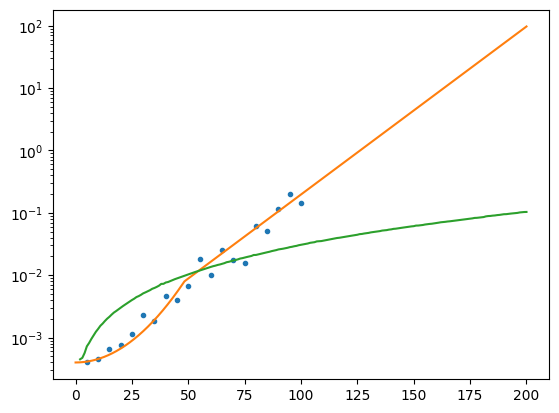

In [42]:
DOMAIN = np.linspace(0, 200, 1000)

xVals = balanced.keys()
yVals = 2 / np.array(list(balanced.values()))*(100e-6)*2

plt.semilogy(xVals, yVals, '.')
plt.semilogy(DOMAIN, 2/func(DOMAIN)*(100e-6)*2)
# plt.semilogy(DOMAIN, 2**(DOMAIN - 1))
plt.semilogy(np.arange(2, 201, 1), classical)
plt.show()

# Plot 5

/var/folders/4l/2_4bm6w152j1zjpfxz3j89y00000gp/T/ipykernel_8731/19766621.py:37: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_b1, pcov_b1 = curve_fit(Mixture, list(balanced1.keys()), list(balanced1.values()), p0=[-.001, -0.062])
/var/folders/4l/2_4bm6w152j1zjpfxz3j89y00000gp/T/ipykernel_8731/19766621.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_b2, pcov_b2 = curve_fit(Mixture, list(balanced2.keys()), list(balanced2.values()), p0=[-.001, -0.062])
/var/folders/4l/2_4bm6w152j1zjpfxz3j89y00000gp/T/ipykernel_8731/19766621.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_u1, pcov_u1 = curve_fit(Mixture, list(uniform1.keys()), list(uniform1.values()), p0=[-.001, -0.062])
/var/folders/4l/2_4bm6w152j1zjpfxz3j89y00000gp/T/ipykernel_8731/19766621.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_u0, pcov_u0 = curve_fit(Mixture, list(uniform0.keys()), list(uniform0

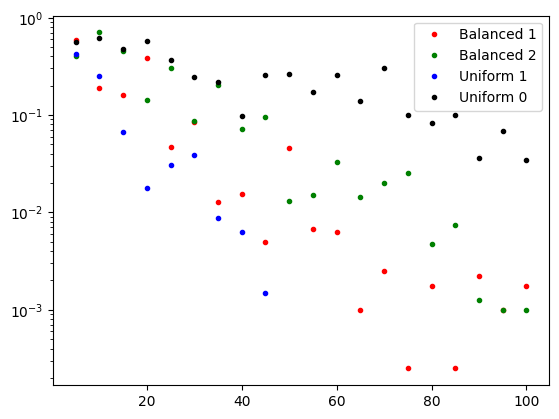

In [26]:
balanced1 = dict()
balanced2 = dict()
uniform1 = dict()
uniform0 = dict()
for filename in os.listdir('../data/balancedPenalties'):
    device, n, time, shots = filename[:-4].split('-')
    n, time, shots = int(n), int(time), int(shots)
    with open(f'../data/balancedPenalties/{filename}') as file:
        counts = file.readlines()
    assert str(int(counts[0].split(' ')[0]) + int(counts[1].split(' ')[0])) == '1' * n
    p1 = (int(counts[0].split(':')[1]))/shots
    p2 = (int(counts[1].split(':')[1]))/shots
    balanced1[n] = p1
    balanced2[n] = p2

for filename in os.listdir('../data/uniformPenalties'):
    device, n, time, shots = filename[:-4].split('-')
    n, time, shots = int(n), int(time), int(shots)
    with open(f'../data/uniformPenalties/{filename}') as file:
        counts = file.readlines()
    if n < 50:
        p1 = (int(counts[0].split(':')[1]))/shots
        p0 = (int(counts[1].split(':')[1]))/shots
        uniform1[n] = p1
    else:
        p0 = (int(counts[0].split(':')[1]))/shots
    
    uniform0[n] = p0

balanced1 = dict(sorted(balanced1.items()))
balanced2 = dict(sorted(balanced2.items()))
uniform1 = dict(sorted(uniform1.items()))
uniform0 = dict(sorted(uniform0.items()))

# popt, pcov = curve_fit(F, list(balanced.keys()), list(balanced.values()), p0=[-.001])

popt_b1, pcov_b1 = curve_fit(Mixture, list(balanced1.keys()), list(balanced1.values()), p0=[-.001, -0.062])
popt_b2, pcov_b2 = curve_fit(Mixture, list(balanced2.keys()), list(balanced2.values()), p0=[-.001, -0.062])
popt_u1, pcov_u1 = curve_fit(Mixture, list(uniform1.keys()), list(uniform1.values()), p0=[-.001, -0.062])
popt_u0, pcov_u0 = curve_fit(Mixture, list(uniform0.keys()), list(uniform0.values()), p0=[-.001, -0.062])

plt.semilogy(balanced1.keys(), balanced1.values(), '.r', label='Balanced 1')
plt.semilogy(balanced2.keys(), balanced2.values(), '.g', label='Balanced 2')
plt.semilogy(uniform1.keys(), uniform1.values(), '.b', label='Uniform 1')
plt.semilogy(uniform0.keys(), uniform0.values(), '.k', label='Uniform 0')
# plt.semilogy(DOMAIN, Mixture(DOMAIN, *popt_b1), 'r', label='Balanced 1')
# plt.semilogy(DOMAIN, Mixture(DOMAIN, *popt_b2), 'g', label='Balanced 2')
# plt.semilogy(DOMAIN, Mixture(DOMAIN, *popt_u1), 'b', label='Uniform 1')
# plt.semilogy(DOMAIN, Mixture(DOMAIN, *popt_u0), 'k', label='Uniform 0')
# plt.semilogy(DOMAIN, np.exp(-0.062*DOMAIN))
# plt.semilogy(DOMAIN, func(DOMAIN))
# plt.ylim(10**-3, 1)
plt.legend(loc='best')
plt.show()
plt.close()

# plt.plot(balanced.keys(), balanced.values(), '.')
# plt.plot(DOMAIN, F(DOMAIN, *popt))
# plt.show()

# print(popt)

In [38]:
650640.0 / 4000

162.66